## Import Data

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as scst
import scipy.signal as sig
import statsmodels.stats.multicomp as thsd
import sys
!{sys.executable} -m pip install pingouin
import pingouin as pg

participants = ['1', '2', '3', '4']
trials_e = ['T1', 'T7', 'T15', 'R1', 'R5']
trials_s = ['T1', 'T2', 'T3', 'T4', 'T5', 'T6', 'T7', 'T8', 'T9', 'T10', 'T11', 'T12', 'T13', 'T14', 'T15', 
            'R1', 'R2', 'R3', 'R4', 'R5']
muscles = ['LRF', 'RRF', 'LBF', 'RBF']

files = []; p_ind = -1; t_ind = -1; m_ind = -1
EMGsizes = [2040, 2040, 408, 2040]
df = {}; np_df_s = {}; np_df_e = {}; np_df = {} # to store data upon importing

# Import Stabilometer Data
for p in participants:
    d = 'Stabilometer'
    xlFile = pd.ExcelFile(p+'_'+d+'.xlsx') # Import xlsx file
    np_df_s[p+"_"+d] = np.zeros((1999, 20)) # Initialise numpy array, (timepoints x trials)
    for t in trials_s:
        t_ind += 1
        print('Imported: '+p+"_"+d+"_"+t)
        df[p+"_"+d+"_"+t] = pd.read_excel(xlFile, t) # Read corresponding sheet as pandas DataFr.
        np_df_s[p+"_"+d][:,t_ind] = df[p+"_"+d+"_"+t][['Stabilometer Position (Degrees)']].T # pd DataFr. -> numpy array
    t_ind = -1

# Import EMG Data
for p in participants:
    d = 'EMG'
    p_ind += 1
    xlFile = pd.ExcelFile(p+'_'+d+'.xlsx') # Import xlsx file
    np_df_e[p+"_"+d] = np.zeros((EMGsizes[p_ind], 5, 4)) # Initialise numpy array, (timepoints x trials x muscles)
    for t in trials_e:
        t_ind += 1
        df[p+"_"+d+"_"+t] = pd.read_excel(xlFile, t) # Read corresponding sheet as pandas DataFr.
        for m in muscles:
            m_ind += 1
            np_df_e[p+"_"+d][:,t_ind,m_ind] = df[p+"_"+d+"_"+t][[m]].T # pd DataFr. -> numpy array
        print('Imported: '+p+"_"+d+"_"+t)
        m_ind = -1
    t_ind = -1

# Fix Participant 3 xScale
# 'New' participant added, part. 5 = part. 3 with same xScale as the others
# ----- (only for ease of plotting purposes, didn't use this version for processing)
np_df_e['5_EMG'] = np.empty((2040,5,4))
np_df_e['5_EMG'][:,:,:] = np.NaN

# Interpolate part. 3 data to finer resolution
for m in range(4):
    for t in range(5):
        for i in range(408):
            np_df_e['5_EMG'][5*i,t,m] = np_df_e['3_EMG'][i,t,m]
        np_df_e['5_EMG'][2039,t,m] = np_df_e['5_EMG'][2035,t,m]
        a = pd.DataFrame(np_df_e['5_EMG'][:,t,m]).interpolate(method='polynomial',order=2) # 2nd order poly. interpolation
        np_df_e['5_EMG'][:,t,m] = a.to_numpy().T
    

Imported: 1_Stabilometer_T1
Imported: 1_Stabilometer_T2
Imported: 1_Stabilometer_T3
Imported: 1_Stabilometer_T4
Imported: 1_Stabilometer_T5
Imported: 1_Stabilometer_T6
Imported: 1_Stabilometer_T7
Imported: 1_Stabilometer_T8
Imported: 1_Stabilometer_T9
Imported: 1_Stabilometer_T10
Imported: 1_Stabilometer_T11
Imported: 1_Stabilometer_T12
Imported: 1_Stabilometer_T13
Imported: 1_Stabilometer_T14
Imported: 1_Stabilometer_T15
Imported: 1_Stabilometer_R1
Imported: 1_Stabilometer_R2
Imported: 1_Stabilometer_R3
Imported: 1_Stabilometer_R4
Imported: 1_Stabilometer_R5
Imported: 2_Stabilometer_T1
Imported: 2_Stabilometer_T2
Imported: 2_Stabilometer_T3
Imported: 2_Stabilometer_T4
Imported: 2_Stabilometer_T5
Imported: 2_Stabilometer_T6
Imported: 2_Stabilometer_T7
Imported: 2_Stabilometer_T8
Imported: 2_Stabilometer_T9
Imported: 2_Stabilometer_T10
Imported: 2_Stabilometer_T11
Imported: 2_Stabilometer_T12
Imported: 2_Stabilometer_T13
Imported: 2_Stabilometer_T14
Imported: 2_Stabilometer_T15
Imported

# Part 1: Stabilometer Plot

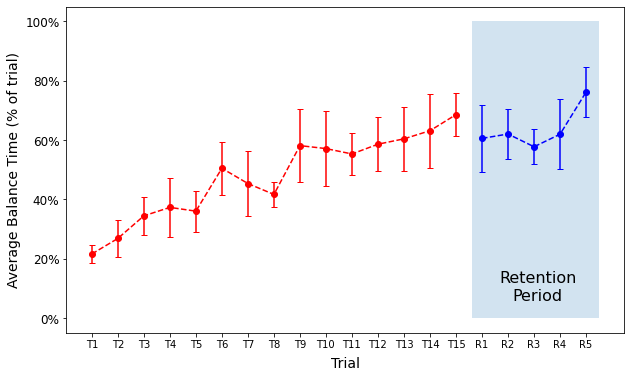

In [50]:
balanced = {} # store True/False time series for balanced/not balanced across all conditions
balanced_freq = np.zeros((20,4)) # store % balanced time across 20 trials x 4 participants

p_ind = -1
for p in participants:
    p_ind += 1
    balanced['p'] = np.where(np.abs(np_df_s[p+'_Stabilometer']) > 5, 0, 1)
    balanced_freq[:,p_ind] = np.mean(balanced['p'], 0)

# Plot average participant balance time across trials    
fig_1, ax = plt.subplots(figsize=(10,6))

ax.errorbar(np.arange(0,15,1), np.mean(100*balanced_freq, 1)[0:15], fmt='ro--', 
            yerr = (np.std(100*balanced_freq, 1)[0:15])/2, capsize=3) # Training trials, SEM errorbars
ax.errorbar(np.arange(15,20,1), np.mean(100*balanced_freq, 1)[15:20], fmt='bo--', 
            yerr = (np.std(100*balanced_freq, 1)[15:20])/2,capsize=3) # Re trials, SEM errorbars

ax.set_ylabel('Average Balance Time (% of trial)', fontsize=14)
ax.set_xlabel('Trial', fontsize=14, labelpad=7)
ax.set_xticks(np.arange(0,20,1)); ax.set_yticks(np.arange(0,101,20))
ax.set_xticklabels(trials_s, fontsize=10); ax.set_yticklabels(['0%','20%','40%','60%','80%','100%'], fontsize=12)
ax.fill_between((14.6,19.5),100, alpha=0.2);
ax.text(15.65,12,'Retention',fontsize=16); ax.text(16.15,6,'Period',fontsize=16);

# Part 2: ANOVA

In [51]:
# Trial T1 data
stabil_T1 = np.concatenate((np_df_s['1_Stabilometer'][:,0], np_df_s['2_Stabilometer'][:,0], 
                         np_df_s['3_Stabilometer'][:,0], np_df_s['4_Stabilometer'][:,0]))
# Trial T15 data
stabil_T15 = np.concatenate((np_df_s['1_Stabilometer'][:,14], np_df_s['2_Stabilometer'][:,14], 
                         np_df_s['3_Stabilometer'][:,14], np_df_s['4_Stabilometer'][:,14]))
# Trial R1 data
stabil_R1 = np.concatenate((np_df_s['1_Stabilometer'][:,15], np_df_s['2_Stabilometer'][:,15], 
                         np_df_s['3_Stabilometer'][:,15], np_df_s['4_Stabilometer'][:,15]))

anova_data = np.zeros((7996, 3))
anova_data[:,0] = stabil_T1; anova_data[:,1] = stabil_T15; anova_data[:,2] = stabil_R1

# Change format for rm_anova
anova_data = pd.DataFrame(anova_data, columns=['T1', 'T15', 'R1'])

# Change format for THSD
tukeyhsd_data = pd.DataFrame({'data': np.concatenate((stabil_T1, stabil_T15, stabil_R1)), 
                       'trials': np.repeat(['T1', 'T15', 'R1'], repeats=len(stabil_T1))})

# # Regular ANOVA
# F_ratio, p_value = scst.f_oneway(stabil_T1, stabil_T15, stabil_R1)
# print('ANOVA F-ratio = '+str(F_ratio))
# print('ANOVA p-value = '+str(p_value))
# print(len(stabil_T1))

# Repeated measures ANOVA
aov = pg.rm_anova(data=anova_data, correction=True)
print('RM ANOVA Results:')
print(aov)
print('')

# Tukey-HSD test
tukey = thsd.pairwise_tukeyhsd(endog=tukeyhsd_data['data'], groups=tukeyhsd_data['trials'],alpha=0.01)

print('Tukey-Test Results:')
print(tukey)

RM ANOVA Results:
   Source  ddof1  ddof2          F         p-unc     p-GG-corr       np2  \
0  Within      2  15990  24.032484  3.788613e-11  1.925722e-09  0.002997   

        eps  sphericity   W-spher  p-spher  
0  0.805834       False  0.759049      0.0  

Tukey-Test Results:
Multiple Comparison of Means - Tukey HSD, FWER=0.01 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
    R1     T1   0.6407  0.001  0.2515  1.0299   True
    R1    T15  -0.2656 0.1151 -0.6548  0.1236  False
    T1    T15  -0.9063  0.001 -1.2955 -0.5171   True
----------------------------------------------------


# Part 3: Mean Muscle Activity

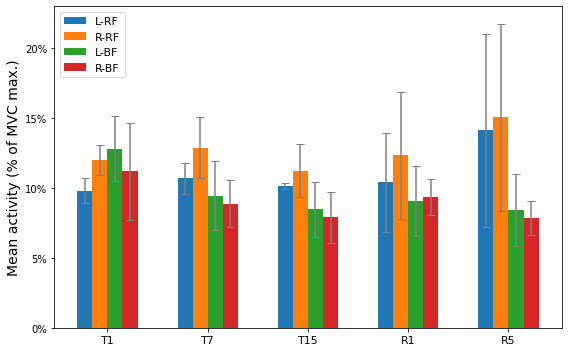

In [52]:
# Muscle Stabilometer Weighting
t_ind = -1; m_ind = -1
np_df_e_w = {} # weighted data
participants_fixed = ['1', '2', '5', '4']; stabilometer_trial_indices = [0, 6, 14, 15, 19]

for p in participants_fixed:
    p_s = '3' if p == '5' else p # participant 3 xScale issue
    np_df_e_w[p+'_EMG'] = np.zeros((1994,5,4)) # weighted data, (timepoints x trials x muscles)
    for t in trials_e:
        t_ind += 1
        for m in muscles:
            m_ind += 1
#            # Consider only out of balance timepoints
#             np_df_e_w[p+'_EMG'][:,t_ind,m_ind] = np.multiply(np_df_e[p+'_EMG'][:1994,t_ind,m_ind],
#                             np.where(np.abs(np_df_s[p_s+'_Stabilometer'][5:,stabilometer_trial_indices[t_ind]])>5, 1, 0))
#             # Consider only in balance timepoints
#             np_df_e_w[p+'_EMG'][:,t_ind,m_ind] = np.multiply(np_df_e[p+'_EMG'][:1994,t_ind,m_ind],
#                             np.where(np.abs(np_df_s[p_s+'_Stabilometer'][5:,stabilometer_trial_indices[t_ind]])>5, 0, 1))
            # Consider all timepoints
            np_df_e_w[p+'_EMG'][:,t_ind,m_ind] = np.multiply(np_df_e[p+'_EMG'][:1994,t_ind,m_ind],
                            np.where(np.abs(np_df_s[p_s+'_Stabilometer'][5:,stabilometer_trial_indices[t_ind]])>5, 1, 1))
        m_ind = -1
    t_ind = -1


# Calculating mean activity & SEM
temp = np.zeros((4,5,4)) # (part. x trials x muscles)
temp_mean = np.zeros((5,4)); temp_stdev = np.zeros((5,4)) # (trials x muscles)
muscle_av = np.zeros((5,4)); muscle_sem = np.zeros((5,4)) # (trials x muscles)
p_ind = -1

for p in participants_fixed:
    p_ind += 1
    for t in range(5):
        for m in range(4):
            # Consider only non-zero elements (as per above weighting) for mean
            temp[p_ind,t,m] = np.sum(np_df_e_w[p+'_EMG'][:, t, m])/np.count_nonzero(np_df_e_w[p+'_EMG'][:, t, m])
temp_stdev = np.std(np.dstack((temp[0,:,:], temp[1,:,:], temp[2,:,:], temp[3,:,:])),axis=2)

muscle_av = np.mean(temp, 0)
muscle_sem = temp_stdev/(len(participants)**(1/2))

# Plotting mean activity & SEM
xlabels = ['T1', 'T7', 'T15', 'R1', 'R5']
bar_width = 0.15; x = np.arange(len(xlabels))  # xScale

fig_2, ax = plt.subplots(figsize=(8,5))
ax.bar(x - (3*bar_width)/2, muscle_av[:,0].T, bar_width, label='L-RF')
ax.bar(x - bar_width/2, muscle_av[:,1].T, bar_width, label='R-RF')
ax.bar(x + bar_width/2, muscle_av[:,2].T, bar_width, label='L-BF')
ax.bar(x + (3*bar_width)/2, muscle_av[:,3].T, bar_width, label='R-BF')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Mean activity (% of MVC max.)', fontsize='14')
ax.set_xticks(x)
ax.set_xticklabels(xlabels, fontsize='11')
ax.set_yticks([0, 5, 10, 15, 20])
ax.set_yticklabels(['0%', '5%', '10%', '15%', '20%'], fontsize='10')
ax.legend(fontsize='11')
ax.set_ylim([0, 23])

ax.errorbar(x - (3*bar_width)/2, muscle_av[:,0].T, yerr=muscle_sem[:,0].T,marker='',ls='',ecolor='gray',capsize=4)
ax.errorbar(x - bar_width/2, muscle_av[:,1].T, yerr=muscle_sem[:,1].T,marker='',ls='',ecolor='gray',capsize=4)
ax.errorbar(x + bar_width/2, muscle_av[:,2].T, yerr=muscle_sem[:,2].T,marker='',ls='',ecolor='gray',capsize=4)
ax.errorbar(x + (3*bar_width)/2, muscle_av[:,3].T, yerr=muscle_sem[:,3].T,marker='',ls='',ecolor='gray',capsize=4)

fig_2.tight_layout()

# Part 4: Correlation Function Plot

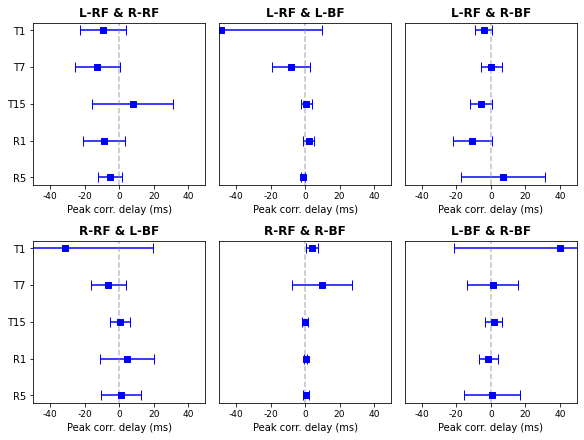

In [53]:
pairs = [[0,1],[0,2],[0,3],[1,2],[1,3],[2,3]] # muscle index pairs
participants_fixed = ['1', '2', '4', '5'] # same xScale for part. 3
corr_matrices = np.zeros((6,4,5)); # (pairs x participants x trials)
pair_ind = -1; p_ind = -1

for pair in pairs:
    pair_ind += 1
    for p in participants_fixed:
        p_ind += 1
        for t in range(len(trials_e)):
            corr_matrices[pair_ind, p_ind, t] = np.argmax(sig.correlate(np_df_e[p+'_EMG'][:,t,pair[0]], 
                            np_df_e[p+'_EMG'][:,t,pair[1]])) - 2039 # max of correlation func, '- 2039' to center around 0
    p_ind = -1

fig_box, ax = plt.subplots(2, 3, figsize=(8,6), constrained_layout=True)
titles = ['L-RF & R-RF', 'L-RF & L-BF', 'L-RF & R-BF', 'R-RF & L-BF', 'R-RF & R-BF', 'L-BF & R-BF'] # muscle pairs

# Time-delay plot
for i in range(6):
    ind = 1 if i > 2 else 0
    ax[ind][i%3].errorbar(x=np.mean(corr_matrices,1).T[:,i], y=np.arange(5, 0, -1), 
                          xerr=np.std(corr_matrices,1).T[:,i], fmt='bs',capsize=5, markersize=6)
    ax[ind][i%3].axvline(x=0, linestyle='--', color='gray', alpha=0.5)
    ax[ind][i%3].set_xlabel('Peak corr. delay (ms)', fontsize='10')
    ax[ind][i%3].set_title(titles[i], fontsize='12', fontweight="bold")
    ax[ind][i%3].set_xlim([-50, 50])
    ax[ind][i%3].set_xticks(np.arange(-40, 41, 20))
    ax[ind][i%3].set_xticklabels(['-40', '-20', '0', '20', '40'], fontsize='9')
    if i%3==0:
        ax[ind][i%3].set_yticks(np.arange(5, 0, -1))
        ax[ind][i%3].set_yticklabels(['T1', 'T7', 'T15', 'R1', 'R5'], fontsize='10')
    else:
        ax[ind][i%3].set_yticks([])


# Part 5: Correlation Coefficient Tables

In [54]:
pairs = [[0,1],[0,2],[0,3],[1,2],[1,3],[2,3]] # muscle index pairs

corr_matrices = np.zeros((6,4,5)); # (pairs x participants x trials)
pair_ind = -1; p_ind = -1

for pair in pairs:
    pair_ind += 1
    for p in participants_fixed:
        p_ind += 1
        for t in range(len(trials_e)):
            corr_matrices[pair_ind, p_ind, t] = np.corrcoef(np_df_e[p+'_EMG'][:,t,pair[0]], 
                                            np_df_e[p+'_EMG'][:,t,pair[1]])[0,1] # calculate correlation coefficient
    p_ind = -1
    
print(np.round(corr_matrices, decimals=4)) # for display purposes

# #Export for excel 
# for i in range(6):
#     np.savetxt(str(i)+'_corr.csv', np.round(corr_matrices[i, :, :], decimals=4), delimiter=",")

[[[ 0.2392  0.2901  0.502   0.4796  0.4832]
  [ 0.0813  0.2368  0.4963  0.42    0.4655]
  [ 0.2877  0.0822  0.0779  0.2628  0.36  ]
  [ 0.2674  0.3721  0.2674  0.4881  0.5358]]

 [[ 0.1333  0.2307  0.5979  0.529   0.5564]
  [ 0.1964  0.3953  0.4815  0.4759  0.4909]
  [ 0.2686  0.4179  0.4164  0.533   0.3177]
  [ 0.3562  0.1229  0.2547  0.4291  0.4456]]

 [[ 0.3419  0.2382  0.5958  0.4356  0.4951]
  [ 0.2031  0.2099  0.6267  0.3783  0.4745]
  [ 0.1894  0.1505  0.0659  0.0381  0.1162]
  [ 0.5863  0.5614  0.6636  0.6701  0.6302]]

 [[-0.0211  0.0694  0.4457  0.3956  0.4336]
  [ 0.1752  0.3625  0.5203  0.5725  0.5132]
  [ 0.4247  0.2229  0.071   0.1334  0.1478]
  [ 0.2957  0.3676  0.1495  0.3398  0.5015]]

 [[ 0.5748  0.2884  0.6463  0.6331  0.5983]
  [ 0.1993  0.2369  0.6011  0.5002  0.6005]
  [ 0.4971  0.2587  0.3983  0.3705  0.3493]
  [ 0.2772  0.6124  0.311   0.6717  0.702 ]]

 [[ 0.0502  0.2519  0.5472  0.4556  0.5238]
  [ 0.0302  0.3328  0.5588  0.5349  0.4985]
  [ 0.3555  0.2704  0.